# Sales Data Analysis and Forecasting Portfolio Project

## Project Overview
In this project, I worked with a fully anonymized business dataset without any specific knowledge about it, with the goal of simply making sense of the dataset, identifying trends, and explore predictive modeling. 

## Dataset Overview
Through my exploration, I found that this dataset spans 9 interconnected tables capturing the complete sales ecosystem of what appears to be a specialty bicycle and accessories retailer. The dataset includes:

### Core Business Components:
- **Product Catalog**: ~2,000 unique products including bikes, components, accessories, and clothing
- **Sales Transactions**: ~1,000 detailed order records
- **Customer Base**: 800+ diverse clients including both individuals and businesses
- **Geographic Coverage**: Sales territories across multiple regions/countries
- **Product Hierarchy**: Multi-level categorization (Categories → Subcategories → Products)


In [105]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.impute import SimpleImputer
import geopandas as gpd
import folium
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame

import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

In [106]:
#path = r"C:\Users\smangla1\Downloads\Business Analytics - Case Study Data.xlsx"
path = 'business_analytics_dataset.xlsx'
df = pd.ExcelFile(path, engine='openpyxl')
product = pd.read_excel(df, 'Product') #product sheet
product_category = pd.read_excel(df, 'ProductCategory')#product category
product_subcategory = pd.read_excel(df, 'ProductSubCategory')
sales_order_header = pd.read_excel(df, 'SalesOrderHeader')
sales_order_detail = pd.read_excel(df, 'SalesOrderDetail')
sales_territory = pd.read_excel(df, 'SalesTerritory')
customers = pd.read_excel(df, 'Customers')

product

,ProductID,Name,ProductNumber,MakeFlag,FinishedGoodsFlag,Color,StandardCost,ListPrice,Size,ProductLine,Class,Style,ProductSubcategoryID,ProductModelID
0,1,Adjustable Race,AR-5381,False,False,NaN,0.0000,0.00,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Bearing Ball,BA-8327,False,False,NaN,0.0000,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,323,Crown Race,CR-9981,False,False,NaN,0.0000,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,325,Decal 1,DC-8732,False,False,NaN,0.0000,0.00,NaN,NaN,NaN,NaN,NaN,NaN
4,326,Decal 2,DC-9824,False,False,NaN,0.0000,0.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,992,"Mountain-500 Black, 48",BK-M18B-48,True,True,Black,294.5797,539.99,48,M,L,U,1.0,23.0
500,993,"Mountain-500 Black, 52",BK-M18B-52,True,True,Black,294.5797,539.99,52,M,L,U,1.0,23.0
501,997,"Road-750 Black, 44",BK-R19B-44,True,True,Black,343.6496,539.99,44,R,L,U,2.0,31.0
502,998,"Road-750 Black, 48",BK-R19B-48,True,True,Black,343.6496,539.99,48,R,L,U,2.0,31.0


In [107]:
product = product[product['ListPrice'] != 0.0] #remove products that aren't sold


In [108]:
percent_missing = product.isnull().sum() * 100 / len(product)
print(percent_missing)


ProductID                0.000000
Name                     0.000000
ProductNumber            0.000000
MakeFlag                 0.000000
FinishedGoodsFlag        0.000000
Color                   19.407895
StandardCost             0.000000
ListPrice                0.000000
Size                    30.592105
ProductLine              8.552632
Class                   22.697368
Style                   30.592105
ProductSubcategoryID     2.960526
ProductModelID           2.960526
dtype: float64


Here I checked to see the percentage of values in each column that are missing. This helps determine whether and how we should impute values or drop rows or columns. Because the percentage of missing data does not cross a significant range for any column and is not insignificant, I will impute numerical columns with median and categorical ones with mode. 

In [148]:
# Separating integer and categorical columns
integer_cols = product.select_dtypes(include=['number']).columns
categorical_cols = product.select_dtypes(include=['object']).columns

# Imputing median for integer columns
imputer_median = SimpleImputer(strategy='median')
product.loc[:,integer_cols] = imputer_median.fit_transform(product[integer_cols])

# Impute mode for categorical columns
imputer_mode = SimpleImputer(strategy='most_frequent')
product.loc[:,categorical_cols] = imputer_mode.fit_transform(product[categorical_cols])


In [110]:
product

,ProductID,Name,ProductNumber,MakeFlag,FinishedGoodsFlag,Color,StandardCost,ListPrice,Size,ProductLine,Class,Style,ProductSubcategoryID,ProductModelID
193,712,AWC Logo Cap,CA-1098,False,True,Multi,6.9223,8.99,44,S,L,U,19.0,2.0
194,514,LL Mountain Seat Assembly,SA-M198,True,False,Black,98.7700,133.34,44,R,L,U,12.0,26.0
195,515,ML Mountain Seat Assembly,SA-M237,True,False,Black,108.9900,147.14,44,R,M,U,12.0,26.0
196,516,HL Mountain Seat Assembly,SA-M687,True,False,Black,145.8700,196.92,44,R,L,U,12.0,26.0
197,517,LL Road Seat Assembly,SA-R127,True,False,Black,98.7700,133.34,44,R,L,U,12.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,992,"Mountain-500 Black, 48",BK-M18B-48,True,True,Black,294.5797,539.99,48,M,L,U,1.0,23.0
500,993,"Mountain-500 Black, 52",BK-M18B-52,True,True,Black,294.5797,539.99,52,M,L,U,1.0,23.0
501,997,"Road-750 Black, 44",BK-R19B-44,True,True,Black,343.6496,539.99,44,R,L,U,2.0,31.0
502,998,"Road-750 Black, 48",BK-R19B-48,True,True,Black,343.6496,539.99,48,R,L,U,2.0,31.0


## General EDA

Here I conduct some basic data visualization to understand baseline information about the dataset before any prediction.

In [111]:
product = pd.merge(product, product_subcategory, on='ProductSubcategoryID')
grouped_category = product.groupby(['ProductCategoryID']).count()
grouped_category

,ProductID,Name_x,ProductNumber,MakeFlag,FinishedGoodsFlag,Color,StandardCost,ListPrice,Size,ProductLine,Class,Style,ProductSubcategoryID,ProductModelID,Name_y
ProductCategoryID,,,,,,,,,,,,,,,
1,97,97,97,97,97,97,97,97,97,97,97,97,97,97,97
2,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143
3,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
4,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29


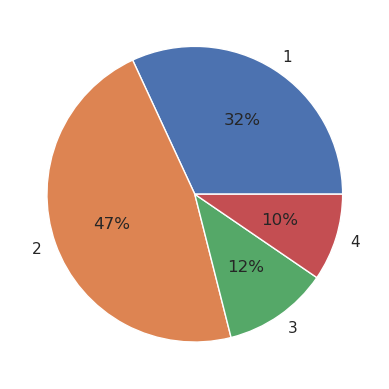

In [112]:
plt.pie(grouped_category['ProductID'], labels=grouped_category.index, autopct='%.0f%%') 
plt.show()

From this pie chart we see that Components (2) and Bikes (1) have the most unique ProductIDs-- the most products.

Now I would like to do some basic location analysis/visualization using geopandas

## Geographic Distribution Analysis & Visualization

Understanding customer distribution across regions would be important for:
- Identifying key markets
- Recognizing potential expansion opportunities
- Analyzing market penetration


In [113]:
sales_territory

,TerritoryID,Name,CountryRegionCode,Group
0,1,Northwest,US,North America
1,2,Northeast,US,North America
2,3,Central,US,North America
3,4,Southwest,US,North America
4,5,Southeast,US,North America
5,6,Canada,CA,North America
6,7,France,FR,Europe
7,8,Germany,DE,Europe
8,9,Australia,AU,Pacific
9,10,United Kingdom,GB,Europe


In [114]:
customer_locations = customers.join(sales_territory.set_index('TerritoryID'), on='TerritoryID')
customer_locations.head()

,CustomerID,PersonID,StoreID,TerritoryID,AccountNumber,Name,CountryRegionCode,Group
0,11015,10963.0,NaN,4,AW00011015,Southwest,US,North America
1,11016,3800.0,NaN,4,AW00011016,Southwest,US,North America
2,11023,4373.0,NaN,4,AW00011023,Southwest,US,North America
3,11024,16843.0,NaN,4,AW00011024,Southwest,US,North America
4,11036,20539.0,NaN,4,AW00011036,Southwest,US,North America
...,...,...,...,...,...,...,...,...
19815,647,NaN,1968.0,4,AW00000647,Southwest,US,North America
19816,648,NaN,1066.0,4,AW00000648,Southwest,US,North America
19817,649,NaN,1376.0,4,AW00000649,Southwest,US,North America
19818,671,NaN,1390.0,4,AW00000671,Southwest,US,North America


In [115]:
grouped_locations = customer_locations.groupby(['Name']).count()
grouped_locations.head()

,CustomerID,PersonID,StoreID,TerritoryID,AccountNumber,CountryRegionCode,Group
Name,,,,,,,
Australia,3665,3625,74,3665,3665,3665,3665
Canada,1791,1677,220,1791,1791,1791,1791
Central,132,69,124,132,132,132,132
France,1884,1844,74,1884,1884,1884,1884
Germany,1852,1812,72,1852,1852,1852,1852
Northeast,113,57,105,113,113,113,113
Northwest,3520,3428,179,3520,3520,3520,3520
Southeast,176,91,164,176,176,176,176
Southwest,4696,4565,246,4696,4696,4696,4696


In [116]:
regions = pd.DataFrame({
    'Name': grouped_locations.index,
    'CustomerCount': grouped_locations['Group']})
regions

,Name,CustomerCount
Name,,
Australia,Australia,3665
Canada,Canada,1791
Central,Central,132
France,France,1884
Germany,Germany,1852
Northeast,Northeast,113
Northwest,Northwest,3520
Southeast,Southeast,176
Southwest,Southwest,4696


In [117]:
country_name_mapping = {
    'Australia': 'Australia',
    'Canada': 'Canada',
    'Central': 'United States of America',
    'France': 'France',
    'Germany': 'Germany',
    'Northeast': 'United States of America',
    'Northwest': 'United States of America',
    'Southeast': 'United States of America',
    'Southwest': 'United States of America',
    'United Kingdom': 'United Kingdom'
}

# Add country names to the DataFrame
regions['CountryName'] = regions['Name'].map(country_name_mapping)

# Load GeoJSON data for countries
geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'

# Initialize the map
m = folium.Map(location=[20, 0], zoom_start=2)

# Add the choropleth layer
folium.Choropleth(
    geo_data=geojson_url,
    name='choropleth',
    data=regions,
    columns=['CountryName', 'CustomerCount'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Customer Count'
).add_to(m)

m.save('customer_count_choropleth_map.html')
m


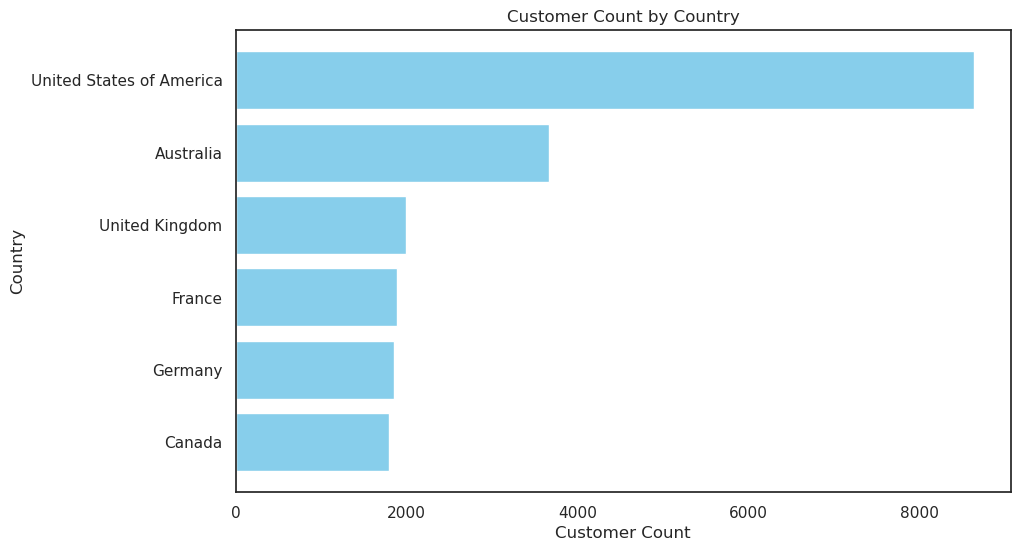

In [118]:

# Aggregate the data by country
aggregated_data = regions.groupby('CountryName').sum().reset_index()

# Sort the data by CustomerCount in descending order
aggregated_data = aggregated_data.sort_values(by='CustomerCount', ascending=False)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(aggregated_data['CountryName'], aggregated_data['CustomerCount'], color='skyblue')
plt.xlabel('Customer Count')
plt.ylabel('Country')
plt.title('Customer Count by Country')
plt.gca().invert_yaxis()  # To display the country with the most customers at the top
plt.show()

It's clear that the majority of customers for this company are in the United States.

From here, I will analyze customer concentration within the United States itself.

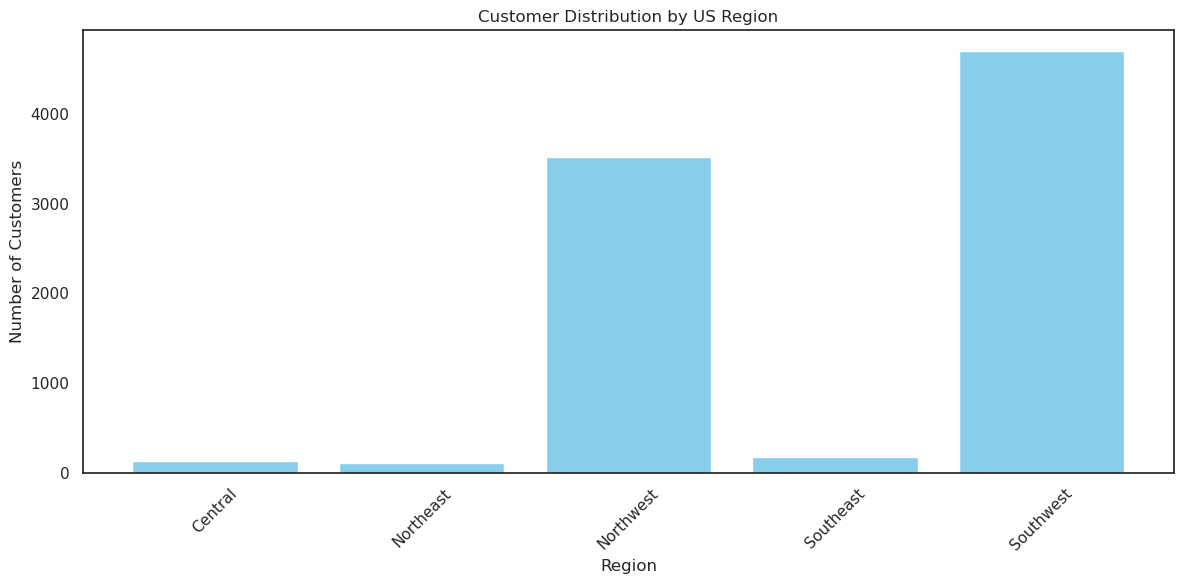

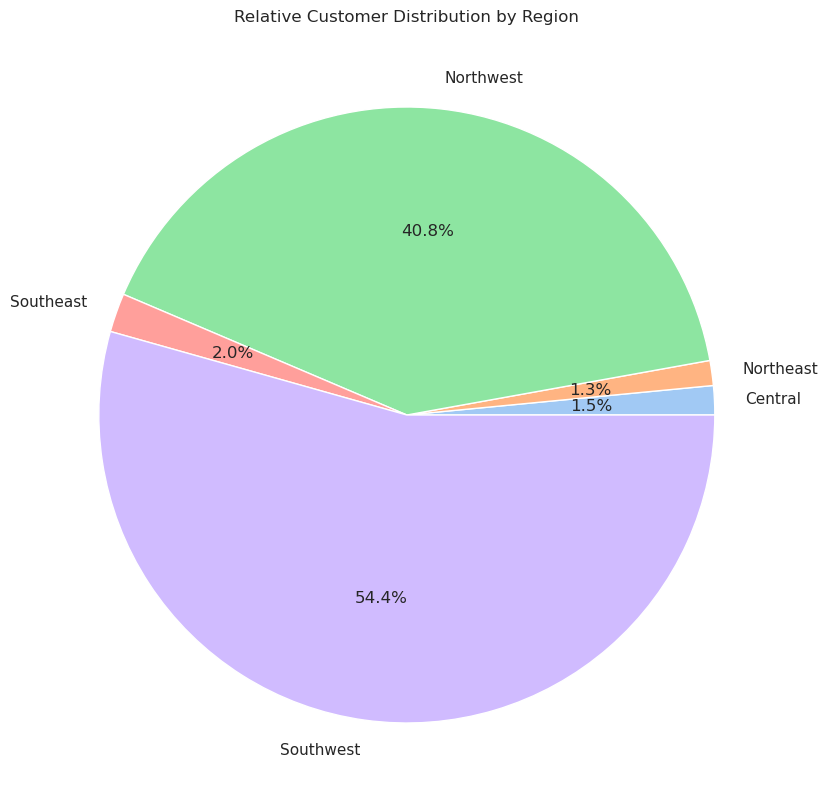

,Name,CustomerCount,Percentage
0,Central,132,1.53
1,Northeast,113,1.31
2,Northwest,3520,40.75
3,Southeast,176,2.04
4,Southwest,4696,54.37



Top 10 States by Estimated Customers:


,State,EstimatedCustomers,Region
40,AZ,670.857143,Southwest
41,CO,670.857143,Southwest
42,NM,670.857143,Southwest
43,OK,670.857143,Southwest
44,TX,670.857143,Southwest
45,UT,670.857143,Southwest
46,CA,670.857143,Southwest
21,ID,502.857143,Northwest
22,MT,502.857143,Northwest
23,OR,502.857143,Northwest


In [119]:
# data mapping
data = {
    'Name': ['Central', 'Northeast', 'Northwest', 'Southeast', 'Southwest'],
    'CustomerCount': [132, 113, 3520, 176, 4696]
}
us_regions = pd.DataFrame(data)

# creating bar chart of regional distribution
plt.figure(figsize=(12, 6))
plt.bar(us_regions['Name'], us_regions['CustomerCount'], color='skyblue')
plt.title('Customer Distribution by US Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# pie chart for relative distribution
plt.figure(figsize=(10, 10))
plt.pie(us_regions['CustomerCount'], 
        labels=us_regions['Name'],
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel'))
plt.title('Relative Customer Distribution by Region')
plt.show()

#summary table with percentages
us_regions['Percentage'] = (us_regions['CustomerCount'] / us_regions['CustomerCount'].sum() * 100).round(2)
display(us_regions)

#state-level data
state_counts = []
state_names = []
state_regions = []

for region, states in state_mapping.items():
    count = us_regions[us_regions['Name'] == region]['CustomerCount'].values[0]
    avg_count = count / len(states)  # Distribute regional count across states
    
    for state in states:
        state_names.append(state)
        state_counts.append(avg_count)
        state_regions.append(region)

state_df = pd.DataFrame({
    'State': state_names,
    'EstimatedCustomers': state_counts,
    'Region': state_regions
})

# summary of state distribution
print("\nTop 10 States by Estimated Customers:")
display(state_df.nlargest(10, 'EstimatedCustomers'))

It appears that the top customers tend to come from the West. It's worth noting that these states are generally correlated with warmer weather, which might explain/correlate positively with this company being a bike-selling one.

# Data Cleaning, Joining, Preprocessing

In [120]:

#sales_order_header = sales_order_header.join(customers.set_index('CustomerID'), on = 'CustomerID')
#sales_order_header = pd.merge(sales_order_header, customers, on='CustomerID', suffixes=('_sales', '_cust'))
#sales = sales_order_detail.join(sales_order_header.set_index('SalesOrderID'), on = 'SalesOrderID')
#product = product.join(sales.set_index('ProductID'), on='ProductID') #join sales_order_detail on productID
product.head()

,ProductID,Name_x,ProductNumber,MakeFlag,FinishedGoodsFlag,Color,StandardCost,ListPrice,Size,ProductLine,Class,Style,ProductSubcategoryID,ProductModelID,ProductCategoryID,Name_y
0,712,AWC Logo Cap,CA-1098,False,True,Multi,6.9223,8.99,44,S,L,U,19.0,2.0,3,Caps
1,514,LL Mountain Seat Assembly,SA-M198,True,False,Black,98.7700,133.34,44,R,L,U,12.0,26.0,2,Mountain Frames
2,515,ML Mountain Seat Assembly,SA-M237,True,False,Black,108.9900,147.14,44,R,M,U,12.0,26.0,2,Mountain Frames
3,516,HL Mountain Seat Assembly,SA-M687,True,False,Black,145.8700,196.92,44,R,L,U,12.0,26.0,2,Mountain Frames
4,517,LL Road Seat Assembly,SA-R127,True,False,Black,98.7700,133.34,44,R,L,U,12.0,26.0,2,Mountain Frames
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,992,"Mountain-500 Black, 48",BK-M18B-48,True,True,Black,294.5797,539.99,48,M,L,U,1.0,23.0,1,Mountain Bikes
300,993,"Mountain-500 Black, 52",BK-M18B-52,True,True,Black,294.5797,539.99,52,M,L,U,1.0,23.0,1,Mountain Bikes
301,997,"Road-750 Black, 44",BK-R19B-44,True,True,Black,343.6496,539.99,44,R,L,U,2.0,31.0,1,Road Bikes
302,998,"Road-750 Black, 48",BK-R19B-48,True,True,Black,343.6496,539.99,48,R,L,U,2.0,31.0,1,Road Bikes


In [121]:
sales = sales_order_detail.join(sales_order_header.set_index('SalesOrderID'), on = 'SalesOrderID')
grp1 = sales.groupby(['ProductID'])
grp1['TotalDue'].agg(['sum', 'mean', 'count'])
#grp.rename(columns = {'sum':'Revenue', 'mean':'AvgRevenueOrder', 'count':'UnitsSold'}, inplace = True)

joined_df = grp1['TotalDue'].agg(['sum', 'mean', 'count']).join(product.set_index('ProductID'), how='inner')
joined_df.head()


,sum,mean,count,Name_x,ProductNumber,MakeFlag,FinishedGoodsFlag,Color,StandardCost,ListPrice,Size,ProductLine,Class,Style,ProductSubcategoryID,ProductModelID,ProductCategoryID,Name_y
ProductID,,,,,,,,,,,,,,,,,,
707,4.327052e+07,14035.198171,3083,"Sport-100 Helmet, Red",HL-U509-R,False,True,Red,13.0863,34.99,44,S,L,U,31.0,33.0,4,Helmets
708,4.495848e+07,14951.273828,3007,"Sport-100 Helmet, Black",HL-U509,False,True,Black,13.0863,34.99,44,S,L,U,31.0,33.0,4,Helmets
709,8.223046e+06,43739.604910,188,"Mountain Bike Socks, M",SO-B909-M,False,True,White,3.3963,9.50,M,M,L,U,23.0,18.0,3,Socks
710,1.088357e+06,24735.385316,44,"Mountain Bike Socks, L",SO-B909-L,False,True,White,3.3963,9.50,L,M,L,U,23.0,18.0,3,Socks
711,4.625477e+07,14969.181451,3090,"Sport-100 Helmet, Blue",HL-U509-B,False,True,Blue,13.0863,34.99,44,S,L,U,31.0,33.0,4,Helmets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,7.972108e+06,53147.389412,150,LL Bottom Bracket,BB-7421,True,True,Black,23.9716,53.99,44,R,L,U,5.0,95.0,2,Bottom Brackets
996,9.844512e+06,45158.312876,218,HL Bottom Bracket,BB-9108,True,True,Black,53.9416,121.49,44,R,H,U,5.0,97.0,2,Bottom Brackets
997,5.632454e+06,12086.811433,466,"Road-750 Black, 44",BK-R19B-44,True,True,Black,343.6496,539.99,44,R,L,U,2.0,31.0,1,Road Bikes


In [122]:
joined_df.rename(columns = {'sum':'Revenue', 'mean':'AvgRevenueOrder', 'count':'UnitsSold'}, inplace = True)
joined_df.head()

,Revenue,AvgRevenueOrder,UnitsSold,Name_x,ProductNumber,MakeFlag,FinishedGoodsFlag,Color,StandardCost,ListPrice,Size,ProductLine,Class,Style,ProductSubcategoryID,ProductModelID,ProductCategoryID,Name_y
ProductID,,,,,,,,,,,,,,,,,,
707,4.327052e+07,14035.198171,3083,"Sport-100 Helmet, Red",HL-U509-R,False,True,Red,13.0863,34.99,44,S,L,U,31.0,33.0,4,Helmets
708,4.495848e+07,14951.273828,3007,"Sport-100 Helmet, Black",HL-U509,False,True,Black,13.0863,34.99,44,S,L,U,31.0,33.0,4,Helmets
709,8.223046e+06,43739.604910,188,"Mountain Bike Socks, M",SO-B909-M,False,True,White,3.3963,9.50,M,M,L,U,23.0,18.0,3,Socks
710,1.088357e+06,24735.385316,44,"Mountain Bike Socks, L",SO-B909-L,False,True,White,3.3963,9.50,L,M,L,U,23.0,18.0,3,Socks
711,4.625477e+07,14969.181451,3090,"Sport-100 Helmet, Blue",HL-U509-B,False,True,Blue,13.0863,34.99,44,S,L,U,31.0,33.0,4,Helmets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,7.972108e+06,53147.389412,150,LL Bottom Bracket,BB-7421,True,True,Black,23.9716,53.99,44,R,L,U,5.0,95.0,2,Bottom Brackets
996,9.844512e+06,45158.312876,218,HL Bottom Bracket,BB-9108,True,True,Black,53.9416,121.49,44,R,H,U,5.0,97.0,2,Bottom Brackets
997,5.632454e+06,12086.811433,466,"Road-750 Black, 44",BK-R19B-44,True,True,Black,343.6496,539.99,44,R,L,U,2.0,31.0,1,Road Bikes


Here we identify which categorical variables can be one-hot-encoded based on how many unique elements are in each column

In [123]:
joined_df.nunique()

Revenue                 266
AvgRevenueOrder         266
UnitsSold               218
Name_x                  266
ProductNumber           266
MakeFlag                  2
FinishedGoodsFlag         1
Color                     8
StandardCost            100
ListPrice                92
Size                     18
ProductLine               4
Class                     3
Style                     3
ProductSubcategoryID     35
ProductModelID          107
ProductCategoryID         4
Name_y                   35
dtype: int64

In [125]:
#dropping categorical variables "Name" "Size" and "ProductNumber". the other categorical variables can be one hot encoded
joined_df = joined_df.drop(['Name_x', 'Name_y','ProductNumber', 'Size'], axis=1)

In [126]:
joined_df = pd.get_dummies(joined_df)
joined_df.head()

,Revenue,AvgRevenueOrder,UnitsSold,MakeFlag,FinishedGoodsFlag,StandardCost,ListPrice,ProductSubcategoryID,ProductModelID,ProductCategoryID,...,ProductLine_M,ProductLine_R,ProductLine_S,ProductLine_T,Class_H,Class_L,Class_M,Style_M,Style_U,Style_W
ProductID,,,,,,,,,,,,,,,,,,,,,
707,4.327052e+07,14035.198171,3083,False,True,13.0863,34.99,31.0,33.0,4,...,False,False,True,False,False,True,False,False,True,False
708,4.495848e+07,14951.273828,3007,False,True,13.0863,34.99,31.0,33.0,4,...,False,False,True,False,False,True,False,False,True,False
709,8.223046e+06,43739.604910,188,False,True,3.3963,9.50,23.0,18.0,3,...,True,False,False,False,False,True,False,False,True,False
710,1.088357e+06,24735.385316,44,False,True,3.3963,9.50,23.0,18.0,3,...,True,False,False,False,False,True,False,False,True,False
711,4.625477e+07,14969.181451,3090,False,True,13.0863,34.99,31.0,33.0,4,...,False,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,7.972108e+06,53147.389412,150,True,True,23.9716,53.99,5.0,95.0,2,...,False,True,False,False,False,True,False,False,True,False
996,9.844512e+06,45158.312876,218,True,True,53.9416,121.49,5.0,97.0,2,...,False,True,False,False,True,False,False,False,True,False
997,5.632454e+06,12086.811433,466,True,True,343.6496,539.99,2.0,31.0,1,...,False,True,False,False,False,True,False,False,True,False


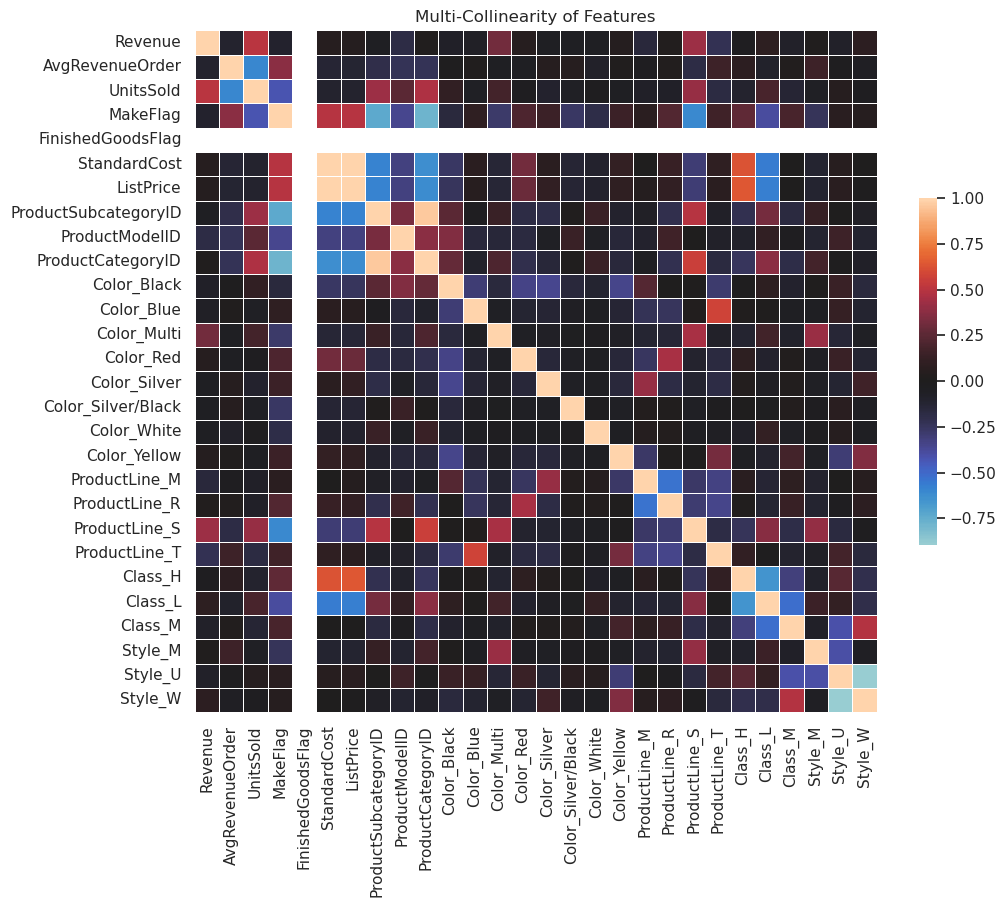

In [127]:
sns.set(style="white")
corr = joined_df.corr() #covariance matrix

# Creating a mask the size of  covariance matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,vmax=1,center=0,square=True, 
            linewidth=.5, cbar_kws={'shrink': .5})
ax.set_title('Multi-Collinearity of Features')
plt.savefig('correlation2.png')

Based on the correlation heatmap, it is doubtful that these features will be linearly predictive of revenue and units sold

## Time Series Analysis and Sales Forecasting

After exploring static relationships in the data, I will turn to temporal patterns:
1. Daily and monthly sales trends
2. Seasonality patterns
3. Sales forecasting using SARIMA modeling

In [128]:
sales.columns

Index(['SalesOrderID', 'SalesOrderDetailID', 'CarrierTrackingNumber',
       'OrderQty', 'ProductID', 'SpecialOfferID', 'UnitPrice',
       'UnitPriceDiscount', 'LineTotal', 'RevisionNumber', 'OrderDate',
       'DueDate', 'ShipDate', 'Status', 'OnlineOrderFlag', 'SalesOrderNumber',
       'PurchaseOrderNumber', 'AccountNumber', 'CustomerID', 'SalesPersonID',
       'TerritoryID', 'BillToAddressID', 'ShipToAddressID', 'ShipMethodID',
       'CreditCardID', 'CreditCardApprovalCode', 'CurrencyRateID', 'SubTotal',
       'TaxAmt', 'Freight', 'TotalDue'],
      dtype='object')

In [129]:
condensed_sales = sales[['OrderDate', 'ProductID', 'TerritoryID','UnitPrice', 'TotalDue']]
condensed_sales

,OrderDate,ProductID,TerritoryID,UnitPrice,TotalDue
0,2013-05-30,870,8,4.990,2580.1419
1,2013-05-30,870,8,4.990,2809.2526
2,2013-05-31,870,8,4.990,2591.1808
3,2013-05-31,870,9,4.990,706.0398
4,2013-05-31,870,9,4.990,2562.4508
...,...,...,...,...,...
121312,2013-10-30,949,2,105.294,40002.3971
121313,2013-10-30,970,2,728.910,40002.3971
121314,2013-10-30,884,5,32.394,4874.6478
121315,2013-10-30,782,5,1376.994,4874.6478


In [130]:
condensed_sales.loc[:, 'OrderDate'] = pd.to_datetime(condensed_sales['OrderDate'])
condensed_sales

,OrderDate,ProductID,TerritoryID,UnitPrice,TotalDue
0,2013-05-30,870,8,4.990,2580.1419
1,2013-05-30,870,8,4.990,2809.2526
2,2013-05-31,870,8,4.990,2591.1808
3,2013-05-31,870,9,4.990,706.0398
4,2013-05-31,870,9,4.990,2562.4508
...,...,...,...,...,...
121312,2013-10-30,949,2,105.294,40002.3971
121313,2013-10-30,970,2,728.910,40002.3971
121314,2013-10-30,884,5,32.394,4874.6478
121315,2013-10-30,782,5,1376.994,4874.6478


In [131]:
condensed_sales.loc[:, 'OrderDate'] = pd.to_datetime(condensed_sales['OrderDate'])
condensed_sales.loc[:, 'Month'] = condensed_sales['OrderDate'].dt.month
condensed_sales.loc[:, 'Year'] = condensed_sales['OrderDate'].dt.year
condensed_sales.loc[:, 'DayofWeek'] = condensed_sales['OrderDate'].dt.dayofweek
condensed_sales.loc[:, 'Day'] = condensed_sales['OrderDate'].dt.day
condensed_sales = condensed_sales.rename(columns={'TotalDue': 'Sales'})

condensed_sales

,OrderDate,ProductID,TerritoryID,UnitPrice,Sales,Month,Year,DayofWeek,Day
0,2013-05-30,870,8,4.990,2580.1419,5,2013,3,30
1,2013-05-30,870,8,4.990,2809.2526,5,2013,3,30
2,2013-05-31,870,8,4.990,2591.1808,5,2013,4,31
3,2013-05-31,870,9,4.990,706.0398,5,2013,4,31
4,2013-05-31,870,9,4.990,2562.4508,5,2013,4,31
...,...,...,...,...,...,...,...,...,...
121312,2013-10-30,949,2,105.294,40002.3971,10,2013,2,30
121313,2013-10-30,970,2,728.910,40002.3971,10,2013,2,30
121314,2013-10-30,884,5,32.394,4874.6478,10,2013,2,30
121315,2013-10-30,782,5,1376.994,4874.6478,10,2013,2,30


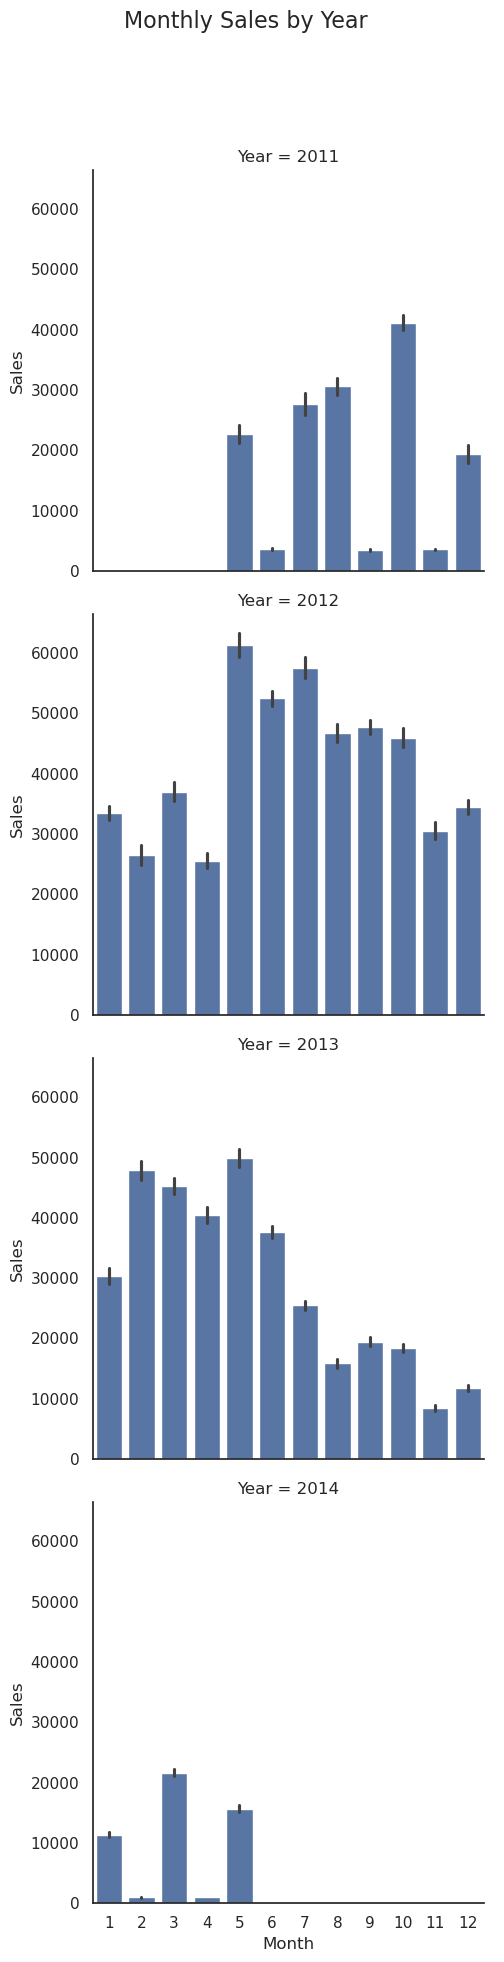

In [132]:
g = sns.catplot(data=condensed_sales, x='Month', y='Sales', 
                row='Year', kind='bar')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Monthly Sales by Year', fontsize=16)

# Show the plot
plt.show()

In [133]:
condensed_sales

,OrderDate,ProductID,TerritoryID,UnitPrice,Sales,Month,Year,DayofWeek,Day
0,2013-05-30,870,8,4.990,2580.1419,5,2013,3,30
1,2013-05-30,870,8,4.990,2809.2526,5,2013,3,30
2,2013-05-31,870,8,4.990,2591.1808,5,2013,4,31
3,2013-05-31,870,9,4.990,706.0398,5,2013,4,31
4,2013-05-31,870,9,4.990,2562.4508,5,2013,4,31
...,...,...,...,...,...,...,...,...,...
121312,2013-10-30,949,2,105.294,40002.3971,10,2013,2,30
121313,2013-10-30,970,2,728.910,40002.3971,10,2013,2,30
121314,2013-10-30,884,5,32.394,4874.6478,10,2013,2,30
121315,2013-10-30,782,5,1376.994,4874.6478,10,2013,2,30


In [134]:
daily_sales = condensed_sales.groupby('OrderDate').agg({'Sales': 'sum'}).reset_index()
daily_sales.set_index('OrderDate', inplace=True)
daily_sales

,Sales
OrderDate,
2011-05-31,8.094970e+06
2011-06-01,1.539433e+04
2011-06-02,1.658846e+04
2011-06-03,7.907977e+03
2011-06-04,1.658846e+04
...,...
2014-06-26,4.344453e+03
2014-06-27,6.200091e+03
2014-06-28,5.276398e+03


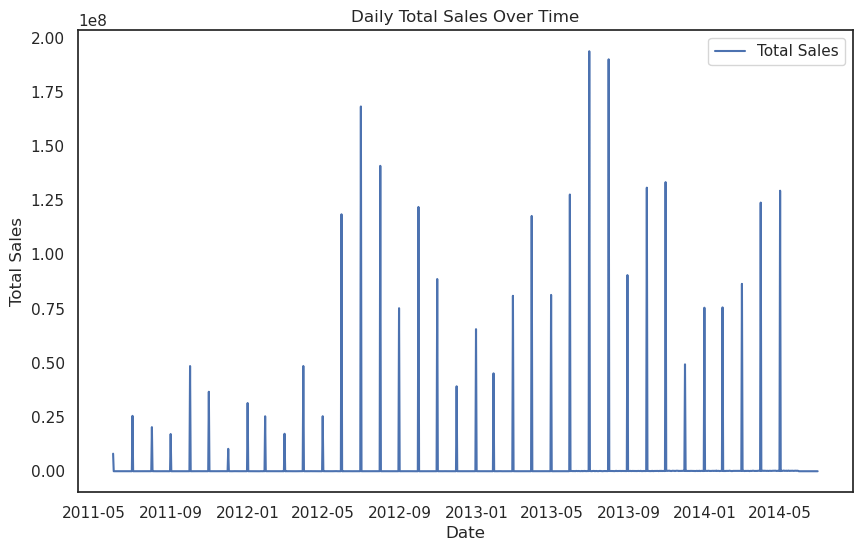

In [135]:
plt.figure(figsize=(10, 6))
plt.plot(daily_sales.index, daily_sales['Sales'], label='Total Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Daily Total Sales Over Time')
plt.legend()
plt.show()

Right off the bat there appears to generally be some trend of increased sales after and around May and before September. This tends to coincide with Summer months, at least in the United States where we've already established most of the customers are. Also taking into account that bikes and bike components are the highest selling items, this gives an initial working hypothesis that potential increased riding time, vacation time, etc may drive sales in the summer for both riding and building/fixing bikes

<Axes: xlabel='Day', ylabel='Sales'>

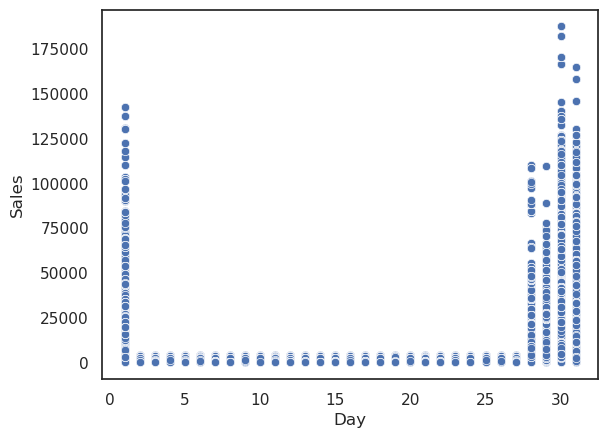

In [136]:
sns.scatterplot(data = condensed_sales, x = "Day", y = "Sales")

Potential insight-- it looks like majority of order dates are beginning and end of the month

<Axes: xlabel='DayofWeek', ylabel='Sales'>

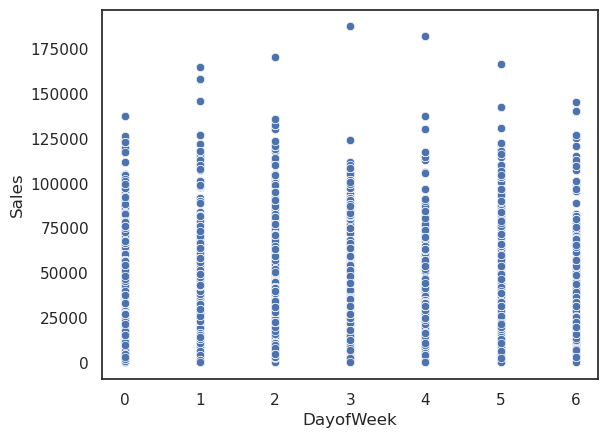

In [137]:
sns.scatterplot(data = condensed_sales, x = "DayofWeek", y = "Sales")

Does not appear to be a clear pattern for day of actual week

Checking Stationariness of Time Series Data. Need to check if stats like mean, variance, etc are constant:

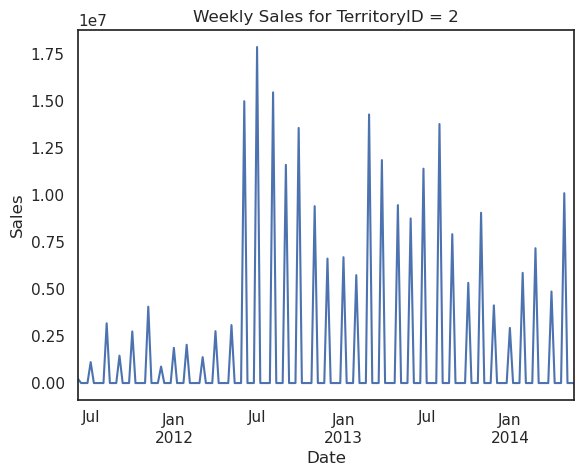

In [138]:
condensed_sales['OrderDate'] = pd.to_datetime(condensed_sales['OrderDate'])
condensed_sales.set_index('OrderDate', inplace=True)

sales_a = condensed_sales[condensed_sales.TerritoryID == 2]['Sales']

# Resample and plot the data
sales_a.resample('W').sum().plot()
plt.title('Weekly Sales for TerritoryID = 2')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Sales generally appear to peak in the middle months of the year

## Time Series Model Development

To build a forecasting model, I will follow these steps:
1. Test for stationarity using Augmented Dickey-Fuller test
2. Apply appropriate transformations (differencing, seasonal adjustments)
3. Identify optimal model parameters
4. Validate model performance



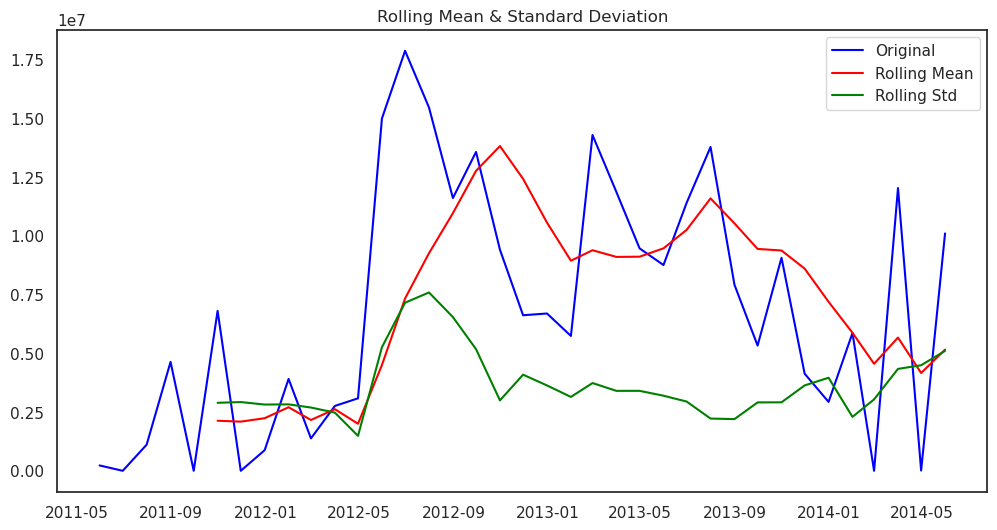

Results of Dickey-Fuller Test:
ADF Statistic: -2.196877892230508
p-value: 0.2073805527492903
Critical Values:
   1%: -3.661428725118324
   5%: -2.960525341210433
   10%: -2.6193188033298647


In [139]:
def test_stationarity(timeseries, window=12):
    # rolling statistics
    roll_mean = timeseries.rolling(window=window).mean()
    roll_std = timeseries.rolling(window=window).std()

    # Plotting rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

sales_a = condensed_sales[condensed_sales.TerritoryID == 2]['Sales']
sales_a_monthly = sales_a.resample('M').sum()
test_stationarity(sales_a_monthly, window=6)

We cannot reject the null hypothesis, so the data is not stationary. We will do differencing now to combat nonstationarity

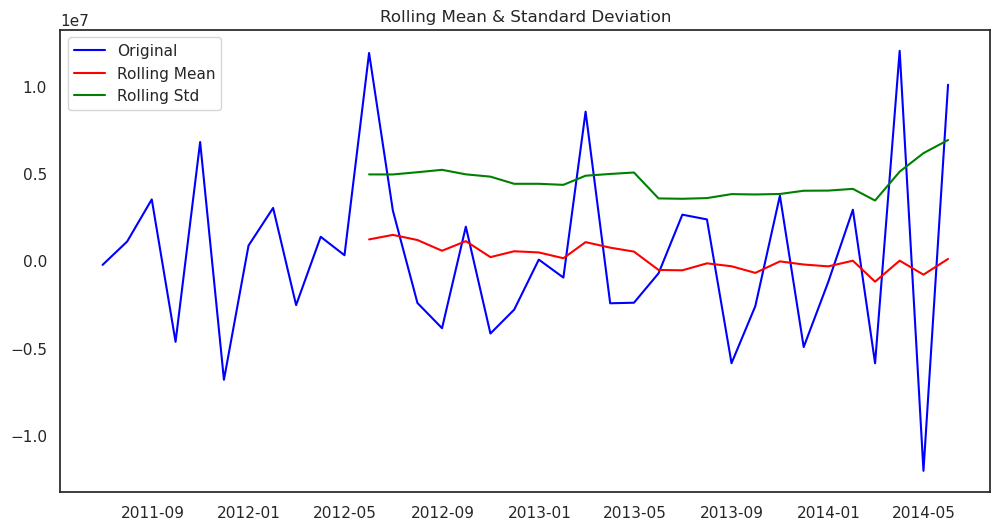

Results of Dickey-Fuller Test:
ADF Statistic: -9.752599942727631
p-value: 7.942305450606535e-17
Critical Values:
   1%: -3.6327426647230316
   5%: -2.9485102040816327
   10%: -2.6130173469387756


In [140]:
# First order differencing
sales_diff = sales_a_monthly.diff().dropna()

# Check stationarity again if needed
test_stationarity(sales_diff)

After differencing, the p-value is significantly less than 0.05 so we can reject the null hypothesis and the data is stationary

Now lets do some decomposition 

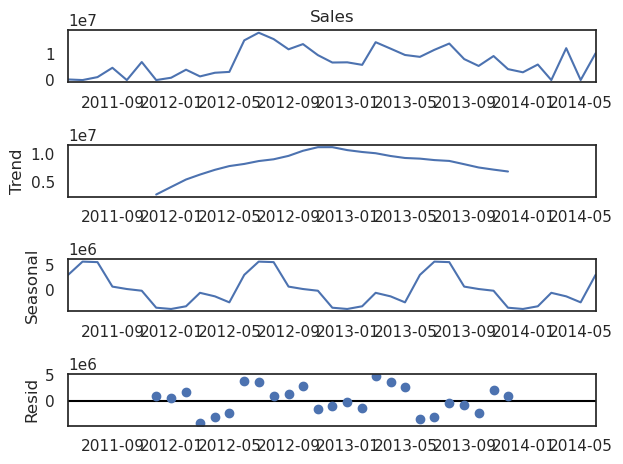

In [141]:
decomposition = seasonal_decompose(sales_a_monthly, model='additive', period = 12)
decomposition.plot()
plt.show()

There seems to be a clear trend of seasonality

In [142]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Grid search
p_values = range(0, 3)
d_values = [1]      
q_values = range(0, 3)
P_values = range(0, 2)
D_values = [1]      
Q_values = range(0, 2)
s = 12

best_aic = float('inf')
best_params = None

print("Searching for optimal SARIMA parameters...")

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            model = SARIMAX(train, 
                                          order=(p, d, q), 
                                          seasonal_order=(P, D, Q, s),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
                            results = model.fit(disp=False)
                            
                            if results.aic < best_aic:
                                best_aic = results.aic
                                best_params = ((p,d,q), (P,D,Q,s))
                        except:
                            continue

print("\nOptimal parameters found:")
print(f"SARIMA{best_params[0]}x{best_params[1]}")
print(f"AIC: {best_aic:.2f}")

Searching for optimal SARIMA parameters...

Optimal parameters found:
SARIMA(0, 1, 2)x(0, 1, 1, 12)
AIC: 140.43


In [143]:
model = SARIMAX(sales_diff, order=(0, 1, 2), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit()

print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11445D+01    |proj g|=  3.23920D-01

At iterate    5    f=  1.09716D+01    |proj g|=  1.68333D-02

At iterate   10    f=  1.09690D+01    |proj g|=  3.03602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   2.270D-06   1.097D+01
  F =   10.968984592008370     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                   36
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -394.883
Date:                              Tue, 29 Oct 2024   AIC                            797.767
Time:                                      07:54:38   BIC                            802.309
Sample:                                  06-30-2011   HQIC                           798.909
                                       - 05-31-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.6054      0.457     -3.516      0.000      -2.500      -0.710
ma.L2          0.66

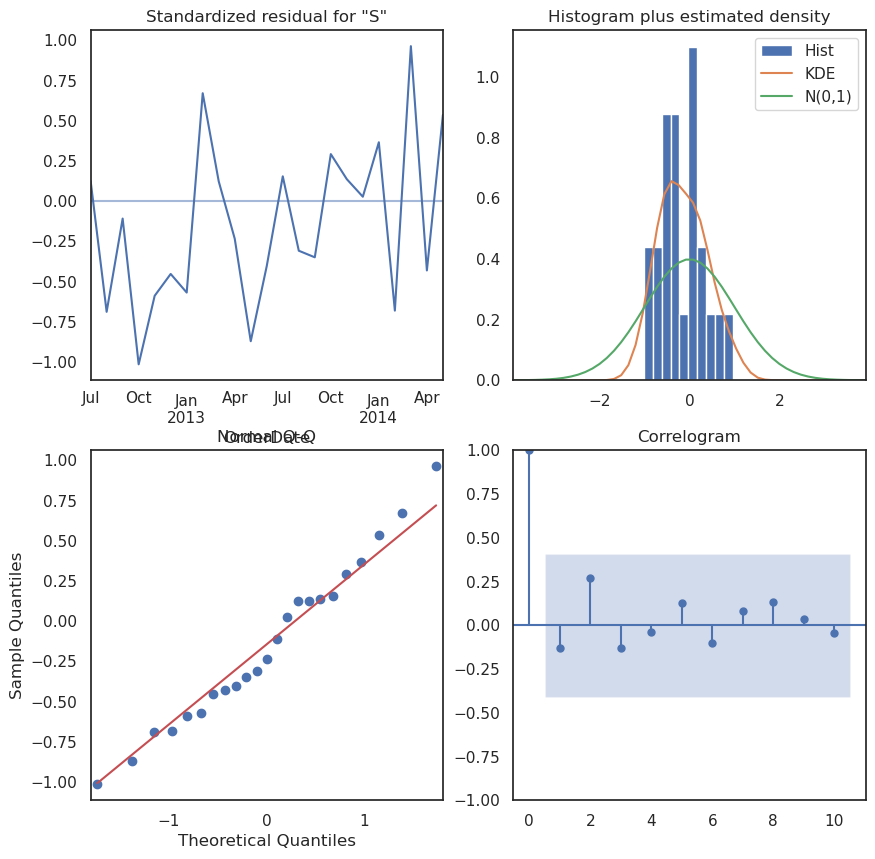

In [144]:
model_fit.plot_diagnostics(figsize=(10, 10))
plt.show()

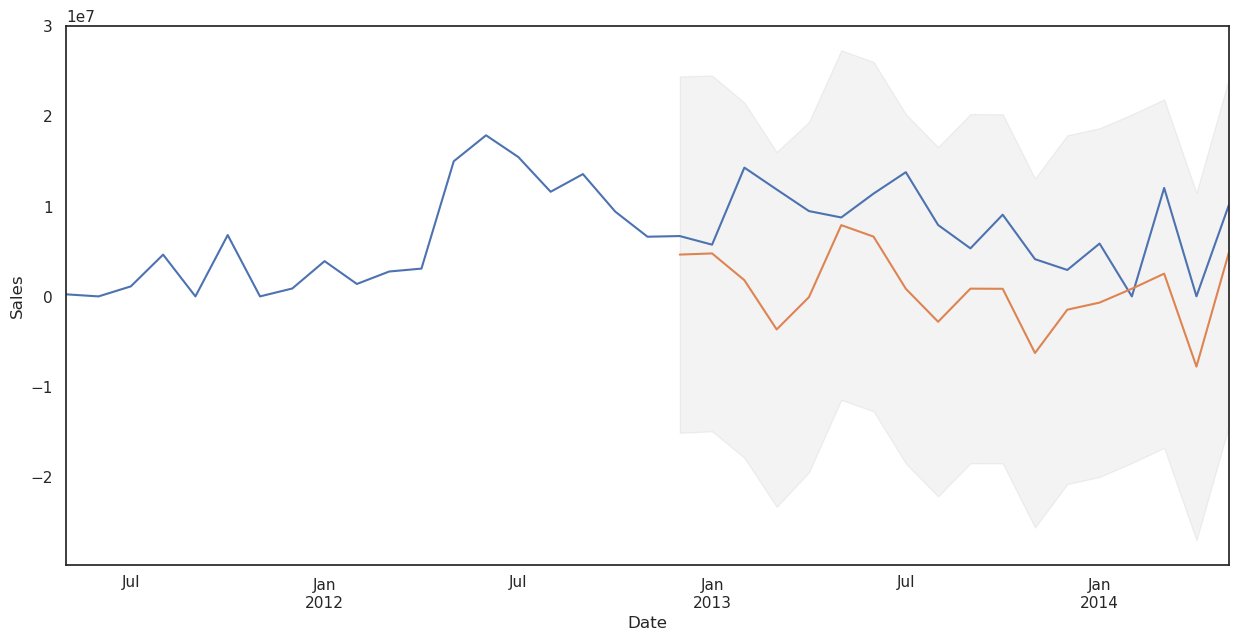

Root Mean Squared Error:  8294250.0667812005


In [145]:
# Model Prediction
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.
pred = model_fit.get_prediction(start=pd.to_datetime('2012-12-31'), dynamic = False)
# Get confidence intervals of forecasts
pred_ci = pred.conf_int()
ax = sales_a_monthly["2011":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
plt.legend
plt.show()
train_arima_forecasted = pred.predicted_mean
train_arima_truth = sales_a_monthly["2012-12-31":]
# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

## Conclusions and Business Recommendations

The analysis reveals several key insights:
1. Strong seasonal patterns in sales, particularly during summer months
2. Geographic concentration in certain regions (Southwest and Northwest)
3. Clear product category dominance (Bikes and Components)

### Potential Recommendations:
1. Adjust inventory planning for seasonal peaks
2. Explore market expansion opportunities in underserved regions
3. Consider product line expansion in high-performing categories

### Model Performance:
- The SARIMA model captures seasonal patterns effectively, but forecasting accuracy could be improved with longer historical data

